In [14]:
import ciao_contrib.runtool
from ciao_contrib.runtool import *
import pandas as pd
import numpy as np
from numpy import load
import astropy 
from astropy.table import Table
from astropy.io import fits
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
import statistics
from IPython.display import clear_output
import sys

# List Folders Function
def list_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    
# Specify path
path = '/Users/steven/Library/CloudStorage/OneDrive-ImperialCollegeLondon/01-27-2023-FYP-CfA/4-Code-Data/Chandra-Data/'
folders = list_folders(path)
folder_list = []
for folder in folders:
    folder_list.append(folder)

# Select Set
set_widget = widgets.Dropdown(options=folder_list[:],value=folder_list[1],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', index=1, options=('Set-2', 'Set-Y', 'Set-5', 'Set-4', 'Set-3', 'Set-6', 'Set-1')…

# 1. Load Data

In [6]:
# Set ID
set_id = set_widget.value.split("-")[1]
# Load data
df_inputs = pd.read_csv(f'{path}Set-{set_id}/inputs-{set_id}.csv')
df_labels = pd.read_csv(f'{path}Set-{set_id}/labels-{set_id}.csv')
# Group data
df_labels = df_labels.drop(columns=['obsreg_id'])
df_inputs = df_inputs.drop(columns=['obsreg_id'])
df_inputs_group = df_inputs.groupby(['obsid', 'region_id'])
df_labels_group = df_labels.groupby(['obsid', 'region_id'])
# Number of unique groups
print(df_inputs_group.ngroups)
print(df_labels_group.ngroups)


179372
119023


In [62]:
# Set ID
set_id = set_widget.value.split("-")[1]
# Load data
df_inputs = pd.read_csv(f'{path}Set-{set_id}/inputs2-{set_id}.csv')
df_labels = pd.read_csv(f'{path}Set-{set_id}/labels2-{set_id}.csv')
# Group data (combined ID)
df_labels_group = df_labels.drop(columns=['obsid', 'region_id'])
df_input_group = df_inputs.drop(columns=['obsid', 'region_id'])
df_labels_group = df_labels.drop(columns=['obsid', 'region_id'])
df_input_group = df_inputs.drop(columns=['obsid', 'region_id'])
df_labels_group = df_labels_group.groupby('obsreg_id')
df_input_group = df_input_group.groupby('obsreg_id')

# 2. Loop over all Eventfile Groups

In [63]:
nbin_E_list = []
nbin_dt_list = []
nbin_t_list = []

sturges_list =[]

scotts_E_list =[]
scotts_dt_list =[]
scotts_t_list =[]

count = 0
fails = 0
count_limit = df_input_group.ngroups
id_fail = []
id_pass = []

for id_name, df_id in df_input_group:
    # Get the dataframe for the current group
    df_id["delta_time"] = df_id['time'].diff()
    df_id = df_id[df_id["delta_time"].notna()]
    # Add a constant value to delta_time = 0
    df_id["delta_time"] = df_id["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.1, dt))
    try:
        # Number and Total Duration of Events
        N = len(df_id)
        T = max(df_id["time"])-min(df_id["time"])
        E = max(df_id["energy"])-min(df_id["energy"])
        # Add delta_t column
        df_id["dt"] = np.log10(100 * N * df_id["delta_time"]/T)
        # Add E column
        df_id["E"] = np.log10(df_id["energy"])
        # Add t column
        df_id["t"] = (df_id["time"] - min(df_id["time"]))/T
        # Freedman-Diaconis rule ENERGY
        iqr_E = np.subtract(*np.percentile(df_id['E'], [75, 25], axis=0)) #IQ range
        binwidth_E = 2 * iqr_E / (len(df_id['E']) ** (1/3))
        nbins_E = int(np.ceil((df_id['E'].max() - df_id['E'].min()) / binwidth_E))
        # Freedman-Diaconis rule DT
        iqr_dt = np.subtract(*np.percentile(df_id['dt'], [75, 25], axis=0)) #IQ range
        binwidth_dt = 2 * iqr_dt / (len(df_id['dt']) ** (1/3))
        nbins_dt = int(np.ceil((df_id['dt'].max() - df_id['dt'].min()) / binwidth_dt))
        # Freedman-Diaconis rule T
        iqr_t = np.subtract(*np.percentile(df_id['t'], [75, 25], axis=0)) #IQ range
        binwidth_t = 2 * iqr_t / (len(df_id['t']) ** (1/3))
        nbins_t = int(np.ceil((df_id['t'].max() - df_id['t'].min()) / binwidth_t))
        # Sturges Rule
        k = int(np.ceil(1 + np.log2(N)))
        # Scotts Rule
        w_E = 3.5 * np.std(df_id['E']) / (N ** (1/3))
        w_dt = 3.5 * np.std(df_id['dt']) / (N ** (1/3))
        w_t = 3.5 * np.std(df_id['t']) / (N ** (1/3))
        k_E = int(np.ceil((df_id['E'].max() - df_id['E'].min()) / w_E))
        k_dt = int(np.ceil((df_id['dt'].max() - df_id['dt'].min()) / w_dt))
        k_t = int(np.ceil((df_id['t'].max() - df_id['t'].min()) / w_t))

        # Append optimal bins lists
        nbin_E_list.append(nbins_E)
        nbin_dt_list.append(nbins_dt)
        nbin_t_list.append(nbins_t)
        sturges_list.append(k)
        scotts_E_list.append(k_E)
        scotts_dt_list.append(k_dt)
        scotts_t_list.append(k_t)

        count = count + 1
        print(f'Counter: {count} / {count_limit}')
        clear_output(wait=True)
        id_pass.append(id_name)
    except:
        fails = fails + 1
        print(f'Fails: {fails}')
        id_fail.append(id_name)
        clear_output(wait=True)

Counter: 83016 / 85056


/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_3927/2284667234.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["delta_time"] = df_id["delta_time"].apply(lambda dt: np.where(dt == 0, dt + 0.1, dt))
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_3927/2284667234.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["dt"] = np.log10(100 * N * df_id["delta_time"]/T)
/var/folders/pr/pzfn3sxs66jfxwx55jdxqrd00000gn/T/ipykernel_3927/2284667234.py:31: SettingWithCopyWarning: 
A

In [17]:
#Describe 
describe = 'smallinput_dt100factorinlog'
# Save FD
with open(f'{path}Set-{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_E_list, file)
with open(f'{path}Set-{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_dt_list, file)
with open(f'{path}Set-{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(nbin_t_list, file)
# Save Sturges
with open(f'{path}Set-{set_id}/n_sturges-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(sturges_list, file)
# Save Scott
with open(f'{path}Set-{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_E_list, file)
with open(f'{path}Set-{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_dt_list, file)
with open(f'{path}Set-{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(scotts_t_list, file)

# Save IDs
with open(f'{path}Set-{set_id}/idpass-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_pass, file)
with open(f'{path}Set-{set_id}/idfail-{set_id}-{describe}.pickle', "wb") as file:
    pickle.dump(id_fail, file)

In [20]:
# Set ID
set_id = set_widget.value.split("-")[1]
#Describe 
describe = 'smallinput_dt100factorinlog'
# Open FD
with open(f'{path}Set-{set_id}/nbin_E_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_dt_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_t_fd-{set_id}-{describe}.pickle', "rb") as file:
    nbin_E_list = pickle.load(file)
# Open Sturges
with open(f'{path}Set-{set_id}/n_sturges-{set_id}-{describe}.pickle', "rb") as file:
    sturges_list = pickle.load(file)
# Open Scott
with open(f'{path}Set-{set_id}/nbin_E_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_dt_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)
with open(f'{path}Set-{set_id}/nbin_t_scott-{set_id}-{describe}.pickle', "rb") as file:
    scotts_t_list = pickle.load(file)

# Open IDs
with open(f'{path}Set-{set_id}/idpass-{set_id}-{describe}.pickle', "rb") as file:
    id_pass = pickle.load(file)
with open(f'{path}Set-{set_id}/idfail-{set_id}-{describe}.pickle', "rb") as file:
    id_fail = pickle.load(file)

In [48]:
index = nbin_E_list.index(2358)
print(index)
print(id_pass[index])

print(np.percentile(nbin_E_list,99))

28467
1561_6986
19.0


Number of Eventfiles:  83016

 Freedman-Diaconis Rule, depends on length of an eventfile and IQR
Min. nE (Freedman-Diaconis): 2
Min. ndt (Freedman-Diaconis):  2
Min. nt (Freedman-Diaconis):  2
Max. nE (Freedman-Diaconis): 2358
Max. ndt (Freedman-Diaconis):  154
Max. nt (Freedman-Diaconis):  2358
Avg. nE (Freedman-Diaconis): 7
Avg. ndt (Freedman-Diaconis):  13
Avg. nt (Freedman-Diaconis):  7
Med. nE (Freedman-Diaconis): 5.0
Med. ndt (Freedman-Diaconis):  10.0
Med. nt (Freedman-Diaconis):  5.0
95percentile nE (Freedman-Diaconis):  11.0
95percentile ndt (Freedman-Diaconis):  26.0
95percentile nt (Freedman-Diaconis):  11.0
90percentile nE (Freedman-Diaconis):  9.0
90percentile ndt (Freedman-Diaconis):  22.0
90percentile nt (Freedman-Diaconis):  9.0
75percentile nE (Freedman-Diaconis):  6.0
75percentile ndt (Freedman-Diaconis):  16.0
75percentile nt (Freedman-Diaconis):  6.0

 Scotts Rule, depends on length of an eventfile and standard deviation
Min. nE (Scotts):  1
Min. ndt (Scotts):  1
Mi

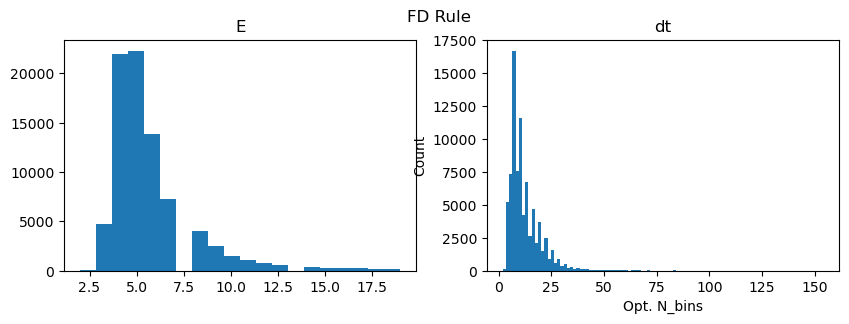

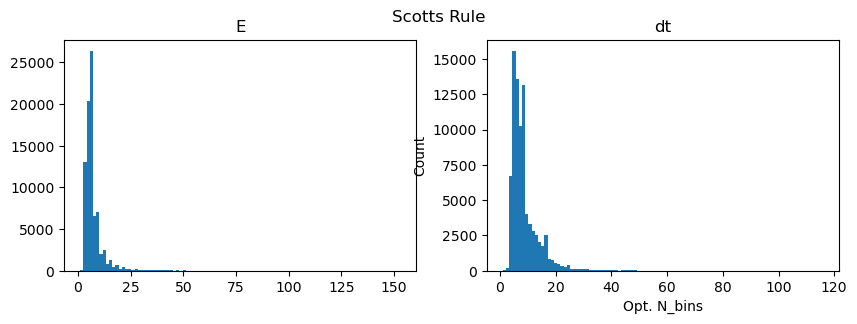

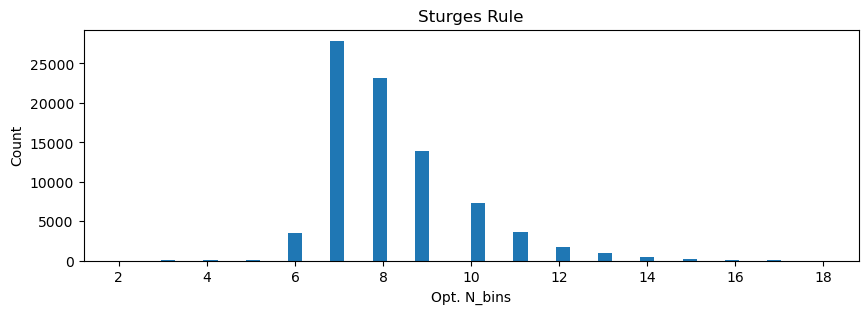

Fails:  ['10147_4', '10303_109', '10303_111', '10303_131', '10303_137', '10303_14', '10303_15', '10303_153', '10303_162', '10303_17', '10303_22', '10303_28', '10303_32', '10303_34', '10303_35', '10303_36', '10303_40', '10303_47', '10303_89', '10324_108', '10324_129', '10324_131', '10324_143', '10324_151', '10324_155', '10324_17', '10324_19', '10324_26', '10324_27', '10324_33', '10324_37', '10324_40', '10324_41', '10324_42', '10324_50', '10324_56', '10324_68', '10324_70', '10324_95', '10324_97', '10368_1', '10548_32', '10549_16', '10549_40', '10549_45', '10549_7', '10845_106', '10845_114', '10845_119', '10845_125', '10845_13', '10845_173', '10845_176', '10845_179', '10845_180', '10845_183', '10845_185', '10845_19', '10845_216', '10845_225', '10845_233', '10845_237', '10845_26', '10845_30', '10845_31', '10845_37', '10845_38', '10845_40', '10845_43', '10845_44', '10845_49', '10845_50', '10845_53', '10845_54', '10845_55', '10845_56', '10845_59', '10845_61', '10845_63', '10845_66', '10845_6

In [61]:
# See Overleaf for advantages and disadvantages etc.
# Thoughts: Best method is the Freedman-Diaconis (FD) rule, but can check bounds of Sturges and Scotts to see if our result with FD falls within that range
# Question is now: Do we use the MAX or AVG for the number of bins (look at distributions!), AVG may not represent the data well in some cases (hides variability), 
# but Max values may be a few single outliers...LOOK AT DISTRIBUTIONS
print("Number of Eventfiles: ", len(sturges_list))

# FD
print('\n Freedman-Diaconis Rule, depends on length of an eventfile and IQR')
print('Min. nE (Freedman-Diaconis):', min(nbin_E_list))
print('Min. ndt (Freedman-Diaconis): ', min(nbin_dt_list))
print('Min. nt (Freedman-Diaconis): ', min(nbin_t_list))
print('Max. nE (Freedman-Diaconis):', max(nbin_E_list))
print('Max. ndt (Freedman-Diaconis): ', max(nbin_dt_list))
print('Max. nt (Freedman-Diaconis): ', max(nbin_t_list))
print('Avg. nE (Freedman-Diaconis):', int(np.ceil(sum(nbin_E_list)/len(nbin_E_list))))
print('Avg. ndt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_dt_list)/len(nbin_dt_list))))
print('Avg. nt (Freedman-Diaconis): ', int(np.ceil(sum(nbin_t_list)/len(nbin_t_list))))
print('Med. nE (Freedman-Diaconis):', statistics.median(nbin_E_list))
print('Med. ndt (Freedman-Diaconis): ', statistics.median(nbin_dt_list))
print('Med. nt (Freedman-Diaconis): ', statistics.median(nbin_t_list))
print('95percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 95))
print('95percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 95))
print('95percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 95))
print('90percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 90))
print('90percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 90))
print('90percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 90))
print('75percentile nE (Freedman-Diaconis): ', np.percentile(nbin_E_list, 75))
print('75percentile ndt (Freedman-Diaconis): ', np.percentile(nbin_dt_list, 75))
print('75percentile nt (Freedman-Diaconis): ', np.percentile(nbin_t_list, 75))

# Scotts
print('\n Scotts Rule, depends on length of an eventfile and standard deviation')
print('Min. nE (Scotts): ', min(scotts_E_list))
print('Min. ndt (Scotts): ', min(scotts_dt_list))
print('Min. nt (Scotts): ', min(scotts_t_list))
print('Max. nE (Scotts): ', max(scotts_E_list))
print('Max. ndt (Scotts): ', max(scotts_dt_list))
print('Max. nt (Scotts): ', max(scotts_t_list))
print('Avg. nE (Scotts): ', int(np.ceil(sum(scotts_E_list)/len(scotts_E_list))))
print('Avg. ndt (Scotts): ', int(np.ceil(sum(scotts_dt_list)/len(scotts_dt_list))))
print('Avg. nt (Scotts): ', int(np.ceil(sum(scotts_t_list)/len(scotts_t_list))))
print('Med. nE (Scotts): ', statistics.median(scotts_E_list))
print('Med. ndt (Scotts): ', statistics.median(scotts_dt_list))
print('Med. nt (Scotts): ', statistics.median(scotts_t_list))
print('95percentile nE (Scotts): ', np.percentile(scotts_E_list, 95))
print('95percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 95))
print('95percentile nt (Scotts): ', np.percentile(scotts_t_list, 95))
print('90percentile nE (Scotts): ', np.percentile(scotts_E_list, 90))
print('90percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 90))
print('90percentile nt (Scotts): ', np.percentile(scotts_t_list, 90))
print('75percentile nE (Scotts): ', np.percentile(scotts_E_list, 75))
print('75percentile ndt (Scotts): ', np.percentile(scotts_dt_list, 75))
print('75percentile nt (Scotts): ', np.percentile(scotts_t_list, 75))

# Sturges
print('\n Sturges Rule, only dependents on length of an eventfile (hence same nbins for E and dt), assumes normal distribution of data')
print('Min. n (Sturges):', min(sturges_list)) # Assumes normal distr tho
print('Max. n (Sturges):', max(sturges_list)) # Assumes normal distr tho
print('Avg. n (Sturges):', int(np.ceil(sum(sturges_list)/len(sturges_list)))) # Assumes normal distr tho
print('Med. n (Sturges):', statistics.median(sturges_list)) # Assumes normal distr tho
print('95percentile n (Sturges): ', np.percentile(sturges_list, 95))
print('90percentile n (Sturges): ', np.percentile(sturges_list, 90))
print('75percentile n (Sturges): ', np.percentile(sturges_list, 75))

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Can also plot them on top of each other for comparison!!!

# IDEA: get only 2-3std away from mean and plot distributions again

# FD Rule
percentile_99 = np.percentile(nbin_E_list, 99)

filtered_list = [x for x in nbin_E_list if x <= percentile_99]


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
fig.suptitle('FD Rule')
#ax1.hist(nbin_E_list,bins=100)
ax1.hist(filtered_list,bins=20)
ax1.set_title('E')
#ax1.set_xlim([np.percentile(nbin_E_list,0), np.percentile(nbin_E_list,99)])
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(nbin_dt_list,bins=100)
ax2.set_title('dt')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Scotts Rule
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 3))
fig.suptitle('Scotts Rule')
ax1.hist(scotts_E_list,bins=100)
ax1.set_title("E")
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
ax2.hist(scotts_dt_list,bins=100)
ax2.set_title("dt")
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')

# Sturges
fig2  = plt.subplots(1, 1,figsize=(10, 3))
plt.hist(sturges_list,bins=50)
plt.title('Sturges Rule')
plt.xlabel('Opt. N_bins')
plt.ylabel('Count')
plt.show()

#Fails 
print("Fails: ", id_fail)